In [1]:
import os
from sklearn.metrics import log_loss,f1_score
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5
import pickle

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]

# train_f4 = pd.read_csv('../input/f4_train.csv', index_col='TransactionID')
# test_f4 = pd.read_csv('../input/f4_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

KeyboardInterrupt: 

In [3]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

NameError: name 'test_transaction' is not defined

In [ ]:
f = open('emb/index_feature.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

for col in "P_emaildomain".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,card2,addr1".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])

# for col in "TransactionDT2".split(","):
#     print(col)
#     for i in range(24):
#         train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])



In [ ]:
print(test_transaction["w2v_"+"TransactionDT2"+"_"+str(1)])

In [ ]:
# import pickle
# f = open('mail_columns_ProNE_32.pickle','rb')
# f_prone = pickle.loads(f.read()) 
# f.close()
# # del f_prone['TransactionID']
# print(f_prone.shape)
# f_prone_train = f_prone.iloc[:train_transaction.shape[0]]
# f_prone_train.index = train_transaction.index
# f_prone_test = f_prone.iloc[train_transaction.shape[0]:]
# f_prone_test.index = test_transaction.index
# f_prone_col = f_prone.columns

In [ ]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [ ]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [ ]:
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"],["card1","P_emaildomain"],["card2","P_emaildomain"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)



for col in [["card2","addr1"],["card1","card2"],["card1","addr1"],["card1","P_emaildomain"],["card2","P_emaildomain"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count) 
    
    col_count1 = train_transaction.groupby(col[0])[col[1]].count()
    col_count2 = train_transaction.groupby("_".join(col))[col[1]].count()
    train_transaction[col[0] +col[1] + '_divide_count'] = train_transaction["_".join(col)].map(col_count2) / (train_transaction[col[0]].map(col_count1) + 0.01)

    col_count1 = test_transaction.groupby(col[0])[col[1]].count()
    col_count2 = test_transaction.groupby("_".join(col))[col[1]].count()
    test_transaction[col[0] +col[1] + '_divide_count'] = test_transaction["_".join(col)].map(col_count2) / (test_transaction[col[0]].map(col_count1) + 0.01)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"],["card1","P_emaildomain"],["card2","P_emaildomain"]]:
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
    
for col in [["card1",["addr1","card2","P_emaildomain"]],["card2",["addr1","P_emaildomain"]]]:
    for col2 in col[1]:
        train_transaction['next'+col[0]+col2+'next'] = train_transaction.groupby(col[0])[col2].shift(-1)
        train_transaction['next'+col[0]+col2+'next'] = (train_transaction['next'+col[0]+col2+'next'] == train_transaction[col2]).astype(int)
        test_transaction['next'+col[0]+col2+'next'] = test_transaction.groupby(col[0])[col2].shift(-1)
        test_transaction['next'+col[0]+col2+'next'] = (test_transaction['next'+col[0]+col2+'next'] == test_transaction[col2]).astype(int)            
#     s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())

# for col in "card1,card2,card3,card5,addr1,addr2".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     for i in range(bin):
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

# train_transaction["addr2"] = train_transaction["addr1"].map(str) + "_" + train_transaction["addr2"].map(str)
# test_transaction["addr2"] = test_transaction["addr1"].map(str) + "_" + test_transaction["addr2"].map(str)
    
#     col_count = train_test.groupby(col)['TransactionDT'].count().fillna(0)
#     col_count = col_count.reset_index()
#     col_count.columns = col + ["_".join(col)+'_count']
#     index = train_transaction.index
#     train_transaction = train_transaction.merge(col_count, how='left', on = col)
#     train_transaction.index = index
#     index = test_transaction.index
#     test_transaction = test_transaction.merge(col_count, how='left', on = col)
#     test_transaction.index = index


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

# train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
# train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
# train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


In [ ]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

In [ ]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [ ]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

In [ ]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_identity.fillna(navalue).groupby(col)['id_01'].count().sort_values()
    col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    col_count = test_identity.fillna(navalue).groupby(col)['id_01'].count().sort_values()
    col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)


In [ ]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

In [ ]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

In [ ]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# del f_prone_train,f_prone_test
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f4, how='left', left_index=True, right_index=True)
# test = test.merge(test_f4, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)



test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [ ]:
print(X_train.shape,X_test.shape)

In [ ]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


In [ ]:
# X_train2 = X_train.copy()
# X_train2['isFraud'] = y_train
# X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# y_train2 = X_train2['isFraud']
# del X_train2['isFraud'],X_train2['hour2'] 


temp = X_train[['TransactionDT','TransactionAmt']].values
folds_index = [([],[]),([],[]),([],[])]
cache = {}
for i in range(temp.shape[0]):
    amt = temp[i,1]
    cache[amt] = cache.get(amt,[])
    cache[amt].append(i)
    l = len(cache[amt])
    folds_num = (int(amt*1000)+l)%3
    folds_index[folds_num][1].append(i)
    for j in range(3):
        if j != folds_num:
            folds_index[j][0].append(i)

for i in range(3):
    folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
    print(folds_index[i],len(folds_index[i][0]))
    


In [ ]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":9,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.6,
        "min_child_weight":2,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.2,
            'reg_lambda' : 0.2,
#     'missing':-999
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),f1_score(y_test,(temp>0.2).astype(int)))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),f1_score(y_test,(y_preds>0.2).astype(int)))

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

In [ ]:
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_test_pred['pred'] = y_preds
# X_test_pred['rank'] =  X_test_pred['pred'].rank()

# true_size = 500
# X_test_psu_index = X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)].index
# X_test_psu,y_test_psu = X_test.loc[X_test_psu_index, :], X_test_pred.loc[X_test_psu_index,'pred'].map(lambda x:1 if x > 0.10 else 0)
# X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)]

In [ ]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

In [ ]:
features = [x for x in X_train.columns if (x not in col_del and  not x.startswith("w2v") and x not in ['TransactionDT'])]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1]
    y_preds11+= temp / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),f1_score(y_test,(temp>0.2).astype(int)))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11),f1_score(y_test,(y_preds11>0.2).astype(int)))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5),f1_score(y_test,(y_preds11*0.5 + y_preds*0.5>0.2).astype(int)))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5)) 

In [ ]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11),f1_score(y_test,(y_preds11>0.2).astype(int)))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5),f1_score(y_test,(y_preds11*0.5 + y_preds*0.5>0.2).astype(int)))


In [ ]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


In [ ]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[-100:].index)
# print(cols)
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:100].index)
# print(cols)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,25))
# sns.barplot(x="importance",
#             y="Feature",
#             data=best_features.sort_values(by="importance",
#                                            ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.savefig('lgbm_importances.png')
# X_train['TransactionDT2']

In [ ]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT'] or x.startswith("w2v")] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or x.startswith("Device") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count") and not x.startswith("nextcard") 
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.7,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 3,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




In [85]:
# X_train['w2v_TransactionDT2_0']
# X_train.columns.tolist()

TransactionID
2987000   -0.892578
2987001   -0.892578
2987002   -0.892578
2987003   -0.892578
2987004   -0.892578
2987005   -0.892578
2987006   -0.892578
2987007   -0.892578
2987008   -0.892578
2987009   -0.892578
2987010   -0.892578
2987011   -0.892578
2987012   -0.892578
2987013   -0.892578
2987014   -0.892578
2987015   -0.892578
2987016   -0.892578
2987017   -0.892578
2987018   -0.892578
2987019   -0.892578
2987020   -0.892578
2987021   -0.892578
2987022   -0.892578
2987023   -0.892578
2987024   -0.892578
2987025   -0.892578
2987026   -0.892578
2987027   -0.892578
2987028   -0.892578
2987029   -0.892578
             ...   
3459402   -0.869629
3459403   -0.869629
3459404   -0.869629
3459405   -0.869629
3459406   -0.869629
3459407   -0.869629
3459408   -0.869629
3459409   -0.869629
3459410   -0.869629
3459411   -0.869629
3459412   -0.869629
3459413   -0.869629
3459414   -0.869629
3459415   -0.869629
3459416   -0.869629
3459417   -0.869629
3459418   -0.869629
3459419   -0.869629
345942

In [86]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if ( not x.startswith("V") )] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in ['card1_TransactionAmt', 'card1_addr1','card1_card2','card1','card7'] 
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'nthread': -1,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
# feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = X_tr.columns
#     fold_importance_df["importance"] = model.feature_importance()
#     fold_importance_df["fold"] = i + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22),log_loss(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 




['ProductCD', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'nthread': -1, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.959921	valid_0's binary_logloss: 0.0579435	valid_1's auc: 0.90596	valid_1's binary_logloss: 0.0980645
[60]	valid_0's auc: 0.969047	valid_0's binary_logloss: 0.0507321	valid_1's auc: 0.915037	valid_1's binary_logloss: 0.0992799
[90]	valid_0's auc: 0.970627	valid_0's binary_logloss: 0.0499278	valid_1's auc: 0.919021	valid_1's binary_logloss: 0.102292
[120]	valid_0's auc: 0.971067	valid_0's binary_logloss: 0.0499801	valid_1's auc: 0.919376	valid_1's binary_logloss: 0.104918
[150]	valid_0's auc: 0.971009	valid_0's binary_logloss: 0.0502311	valid_1's auc: 0.919664	valid_1's binary_logloss: 0.106784
[180]	valid_0's auc: 0.971094	valid_0's binary_logloss: 0.0503893	valid_1's auc: 0.919674	valid_1's binary_logloss: 0.10837
[210]	valid_0's auc: 0.971242	valid_0's binary_logloss: 0.0505808	valid_1's auc: 0.919906	valid_1's binary_logloss: 0.109649
ROC AUC 0.9712026986170725
debug: 0.919694021735153


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.959502	valid_0's binary_logloss: 0.0602858	valid_1's auc: 0.908657	valid_1's binary_logloss: 0.0962328
[60]	valid_0's auc: 0.968629	valid_0's binary_logloss: 0.0533525	valid_1's auc: 0.918854	valid_1's binary_logloss: 0.0980393
[90]	valid_0's auc: 0.970549	valid_0's binary_logloss: 0.0528448	valid_1's auc: 0.921983	valid_1's binary_logloss: 0.101139
[120]	valid_0's auc: 0.970923	valid_0's binary_logloss: 0.0530844	valid_1's auc: 0.923416	valid_1's binary_logloss: 0.104058
[150]	valid_0's auc: 0.971087	valid_0's binary_logloss: 0.0535009	valid_1's auc: 0.923778	valid_1's binary_logloss: 0.106078
[180]	valid_0's auc: 0.971309	valid_0's binary_logloss: 0.0537415	valid_1's auc: 0.923947	valid_1's binary_logloss: 0.107939
[210]	valid_0's auc: 0.971399	valid_0's binary_logloss: 0.054071	valid_1's auc: 0.923697	valid_1's binary_logloss: 0.109435
ROC AUC 0.9715114621256153
debug: 0.9236460271878072


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.960032	valid_0's binary_logloss: 0.0589577	valid_1's auc: 0.911902	valid_1's binary_logloss: 0.0948503
[60]	valid_0's auc: 0.969073	valid_0's binary_logloss: 0.0518047	valid_1's auc: 0.918012	valid_1's binary_logloss: 0.0958718
[90]	valid_0's auc: 0.971067	valid_0's binary_logloss: 0.0510807	valid_1's auc: 0.920836	valid_1's binary_logloss: 0.0986665
[120]	valid_0's auc: 0.971835	valid_0's binary_logloss: 0.0511008	valid_1's auc: 0.920652	valid_1's binary_logloss: 0.101203
[150]	valid_0's auc: 0.972327	valid_0's binary_logloss: 0.0513382	valid_1's auc: 0.920281	valid_1's binary_logloss: 0.102983
[180]	valid_0's auc: 0.972628	valid_0's binary_logloss: 0.0514965	valid_1's auc: 0.920192	valid_1's binary_logloss: 0.104035
[210]	valid_0's auc: 0.972706	valid_0's binary_logloss: 0.0517524	valid_1's auc: 0.919457	valid_1's binary_logloss: 0.105444
ROC AUC 0.9727850171806215
debug: 0.9193769192844341
debug: 0.9297575458770988 0.10358639845916527
debug: 0.9349749458663144 

In [87]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 

debug: 0.9333497011410433 0.083664642118056
debug: 0.9270698151590613 0.09971004788569013
debug: 0.9349749458663144 0.08815536916789148
debug: 0.937783622745966 0.08415493963178283
debug: 0.9393057162355073 0.08291518372784643


Index(['V254', 'V109', 'V157', 'V322', 'V329', 'V71', 'V22', 'V255', 'V16',
       'id_29_count', 'V173', 'id_04_count', 'V101', 'V252', 'V174', 'V21',
       'id_36_count', 'V194', 'V191', 'id_25_count', 'V297', 'addr2_C13count',
       'card6', 'V151', 'V116', 'V141', 'V302', 'V193', 'V111', 'id_21_count',
       'id_35', 'V98', 'V106', 'addr2_count', 'V334', 'V339', 'V104',
       'id_08_count', 'id_21', 'M1', 'V31', 'V196', 'V330', 'V32', 'V138',
       'M1_count', 'V114', 'id_26', 'id_26_count', 'nextcard1card2next',
       'V195', 'id_12_count', 'id_36', 'addr2_amtcount', 'V1', 'V337', 'V327',
       'id_24_count', 'V110', 'V240', 'addr2_C5count', 'V269', 'V14',
       'id_07_count', 'addr2_C8count', 'V41', 'id_02', 'V142', 'id_12', 'V328',
       'id_22', 'V325', 'id_22_count', 'id_23', 'id_23_count', 'id_27', 'V305',
       'id_27_count', 'id_35_count', 'V28', 'V27', 'V117', 'V118', 'card4',
       'V119', 'V113', 'V112', 'V120', 'V121', 'V122', 'V89', 'V88', 'V107',
       'ad

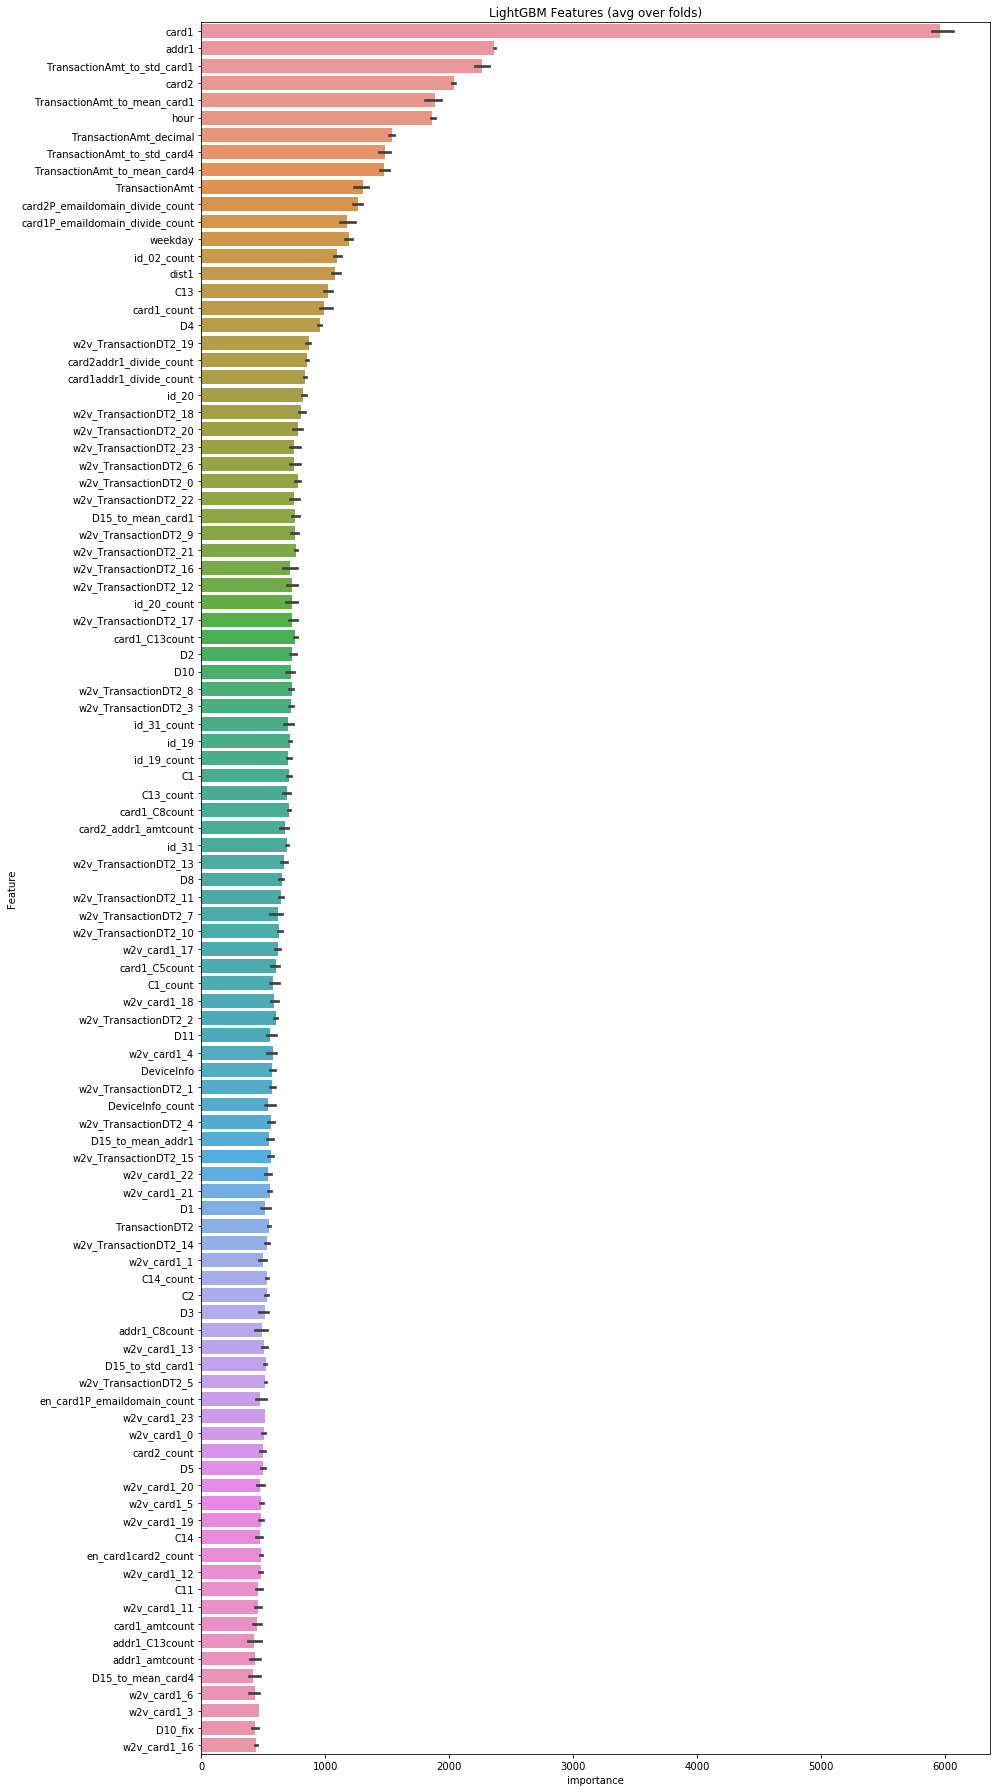

In [88]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [90]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if (x not in col_del )]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss',
                                min_data_in_leaf=15,l2_leaf_reg=3.0
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
    best_iter = num_rounds - 100
    y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    best_iter = num_rounds - 200
    y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

630
['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6139179	total: 1.45s	remaining: 16m 55s
30:	learn: 0.0889949	total: 44.6s	remaining: 16m 2s
60:	learn: 0.0631566	total: 1m 28s	remaining: 15m 22s
90:	learn: 0.0535507	total: 2m 12s	remaining: 14m 49s
120:	learn: 0.0480362	total: 2m 56s	remaining: 14m 4s
150:	learn: 0.0447367	total: 3m 39s	remaining: 13m 17s
180:	learn: 0.0423433	total: 4m 21s	remaining: 12m 30s
210:	learn: 0.0401558	total: 5m 4s	remaining: 11m 45s
240:	learn: 0.0381458	total: 5m 47s	remaining: 11m
270:	learn: 0.0366956	total: 6m 29s	remaining: 10m 16s
300:	learn: 0.0352450	total: 7m 11s	remaining: 9m 32s
330:	learn: 0.0337993	total: 7m 53s	remaining: 8m 48s
360:	learn: 0.0321925	total: 8m 36s	remaining: 8m 5s
390:	learn: 0.0308031	total: 9m 19s	remaining: 7m 22s
420:	learn: 0.0296375	total: 10m 2s	remaining: 6m 39s
450:	learn: 0.0289259	total: 10m 44s	remaining: 5m 55s
480:	learn: 0.0278628	to

In [ ]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


In [ ]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    

In [ ]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline2.csv')
else:
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3
    sample_submission.to_csv('simple_ensemble2.csv')
